In [2]:
import os
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from pathlib import Path
import time
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [3]:
path = '../input/petfinder-pawpularity-score/'

# 将数据读为DataFrame
train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv')

# 读取图片数据
train_jpg = glob(path + "train/*.jpg")
test_jpg = glob(path + "test/*.jpg")

# 查看前五张图片路径
train_jpg[:5]

['../input/petfinder-pawpularity-score/train/7954ebb5c90d9618e34959df0ad5f062.jpg',
 '../input/petfinder-pawpularity-score/train/2969162fab1d0e5a65e4ce02db267745.jpg',
 '../input/petfinder-pawpularity-score/train/9f32ae94d7723414cb8fa881a1c6626c.jpg',
 '../input/petfinder-pawpularity-score/train/b8f920f44800ee71e4659dea84bc9bef.jpg',
 '../input/petfinder-pawpularity-score/train/7fc71b8da143721939715b1cfe22122f.jpg']

In [4]:
# 输出训练集的维度
print('train_df dimensions: ', train_df.shape)

# 输出测试集的维度
print('test_df dimensions: ',test_df.shape)
train_df.head()

train_df dimensions:  (9912, 14)
test_df dimensions:  (8, 13)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


# Exploratory Data Analysis (EDA)

Text(0, 0.5, 'Count')

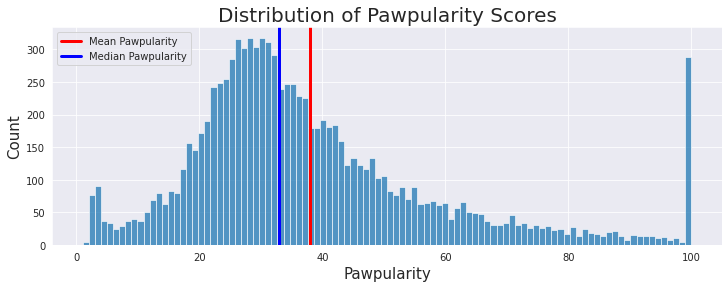

In [5]:
plt.figure(figsize=(12,4))
sns.histplot(data=train_df, x='Pawpularity', bins=100)

plt.axvline(train_df['Pawpularity'].mean(), c='red', ls='-', lw=3, label='Mean Pawpularity')
plt.axvline(train_df['Pawpularity'].median(),c='blue',ls='-',lw=3, label='Median Pawpularity')
plt.title('Distribution of Pawpularity Scores', fontsize=20)
plt.legend()
plt.xlabel('Pawpularity', fontsize=15)
plt.ylabel('Count', fontsize=15)

**Observations:**

* 由于近 300 个条目的 pawpularity 得分为 100，因此分布偏斜。
* 还有一些接近于零的分数。
* 除此之外，数据似乎大致遵循γ分布。

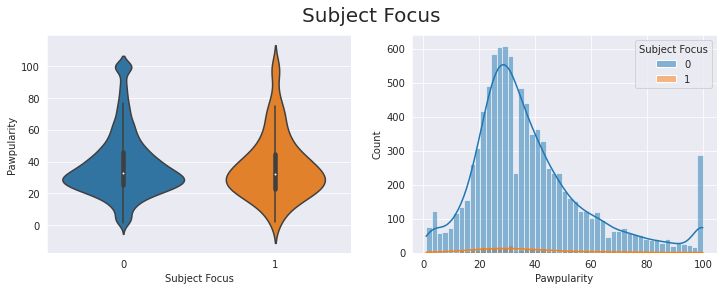

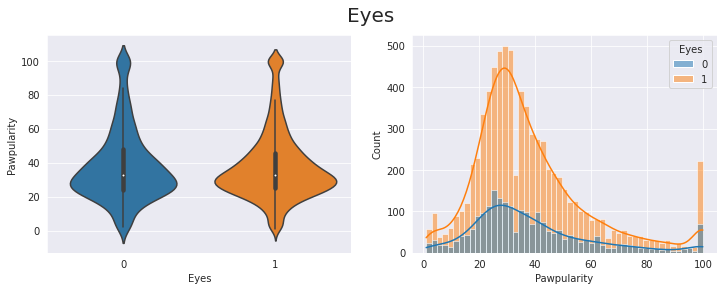

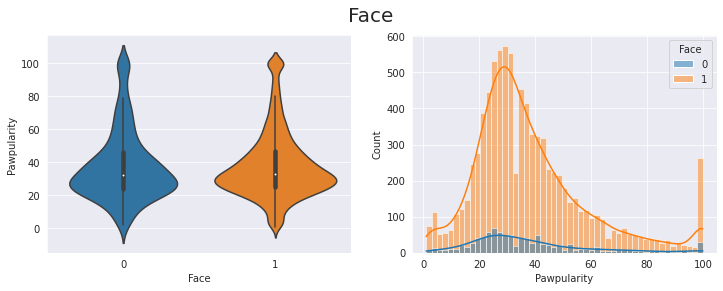

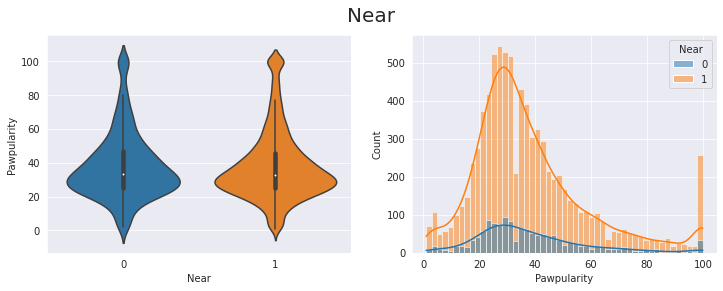

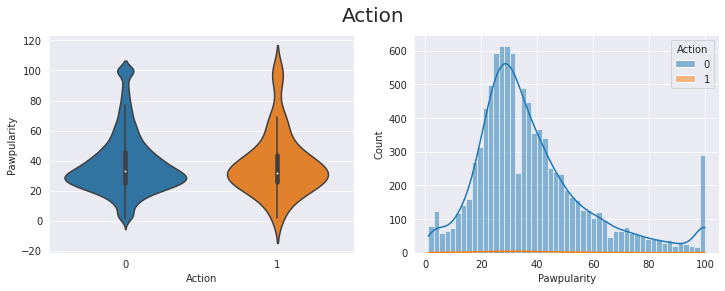

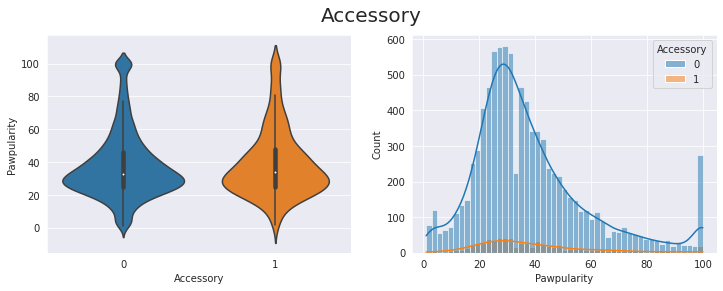

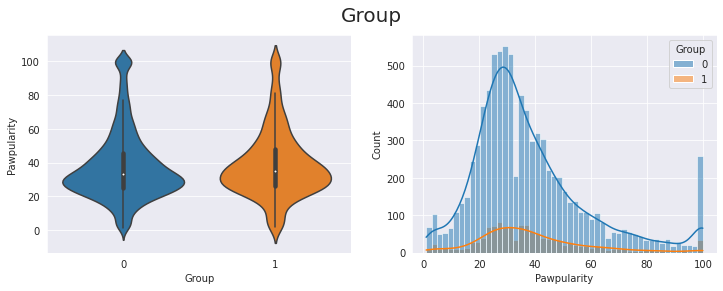

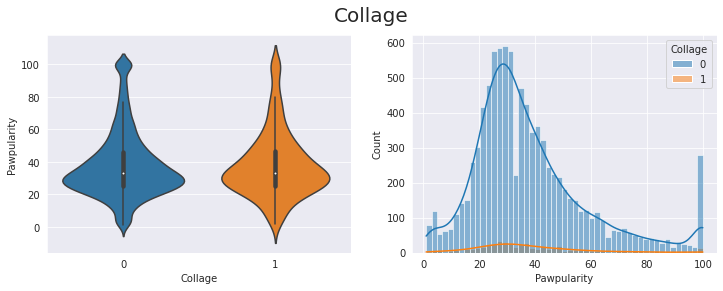

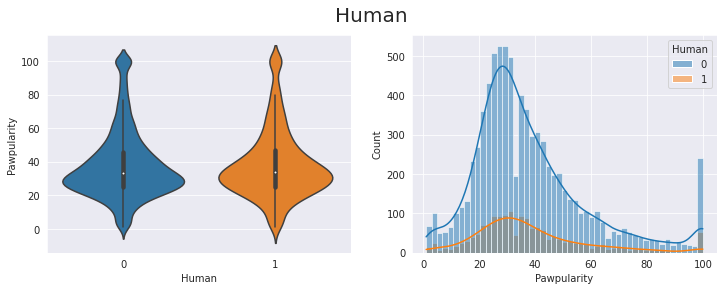

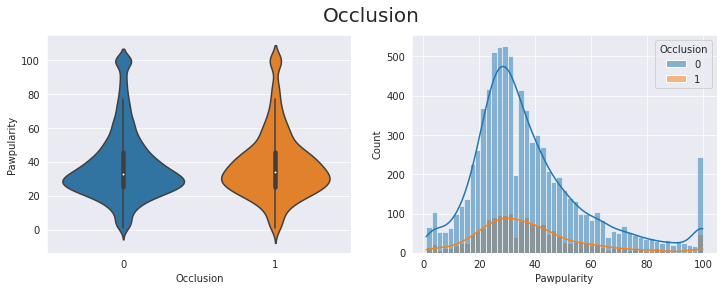

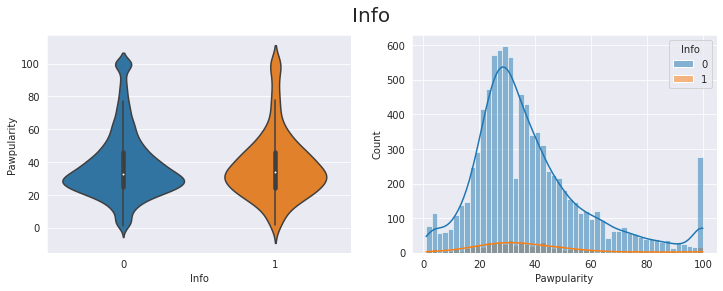

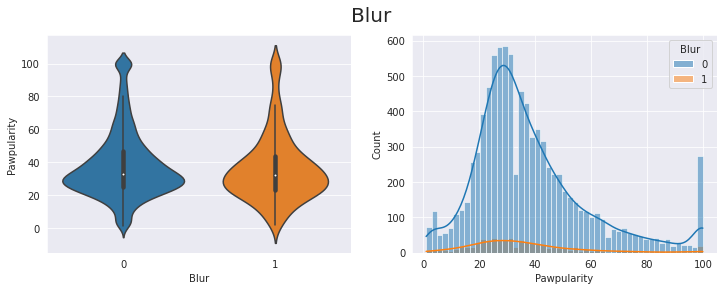

In [6]:
feature_variables = train_df.columns.values.tolist()

for i in feature_variables[1:-1]:
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    sns.violinplot(ax=ax[0], data=train_df, x=i, y='Pawpularity')
    sns.histplot(ax=ax[1], data=train_df, x="Pawpularity", hue=i, kde=True)
    plt.suptitle(i, fontsize=20)
    fig.show()

**Observations:**
* 每个特征中的小提琴图几乎相同。 也就是说，pawpularity 并不严重依赖于这些特征的值。
* 这意味着很难单独训练任何算法来预测这些特征的 pawpularity，可能还需要使用图像。

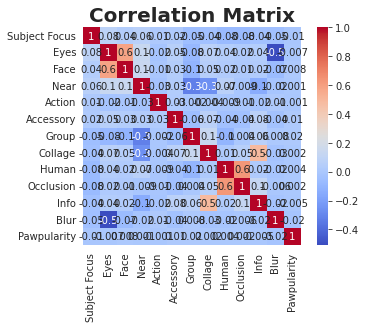

In [7]:
sns.heatmap(train_df.corr(), annot=True, fmt='.1g', cmap='coolwarm', square=True)
plt.title('Correlation Matrix', fontsize=20, fontweight='bold')
plt.show()

**Observations:**
* 我们可以看到一些相关性，但总体而言，预测变量似乎没有提供关于 Pawpularity 分数本身的太多信息。
* 它只是陈述了显而易见的事情。 例如，眼睛和面部具有高度正相关，这意味着如果面部可见，则眼睛也是可见的，反之亦然。 

In [8]:
y = train_df['Pawpularity']
X = train_df.drop(['Id','Pawpularity'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size = 0.2, random_state=0)
print('维度: \n X_train:{} \n X_valid{} \n y_train{} \n y_valid{}'.format(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape))

维度: 
 X_train:(7929, 12) 
 X_valid(1983, 12) 
 y_train(7929,) 
 y_valid(1983,)


# Random Forest Regressor

In [9]:
# 超参调优
n_estimators_range=[int(x) for x in np.linspace(start=50,stop=3000,num=60)]
max_features_range=['auto','sqrt']
max_depth_range=[int(x) for x in np.linspace(10,500,num=50)]
max_depth_range.append(None)
min_samples_split_range=[2,5,10]
min_samples_leaf_range=[1,2,4,8]
bootstrap_range=[True,False]

random_forest_hp_range={'n_estimators':n_estimators_range,
                        'max_features':max_features_range,
                        'max_depth':max_depth_range,
                        'min_samples_split':min_samples_split_range,
                        'min_samples_leaf':min_samples_leaf_range
                        }
print(random_forest_hp_range)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900, 2950, 3000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8]}


In [10]:
from sklearn.model_selection import RandomizedSearchCV
random_seed=44
random_forest_seed=np.random.randint(low=1,high=230)
random_forest_model_test_base=RandomForestRegressor()
random_forest_model_test_random=RandomizedSearchCV(estimator=random_forest_model_test_base,
                                                   param_distributions=random_forest_hp_range,
                                                   n_iter=200,
                                                   n_jobs=-1,
                                                   cv=3,
                                                   verbose=1,
                                                   random_state=random_forest_seed
                                                   )
random_forest_model_test_random.fit(X_train,y_train)

best_hp_now=random_forest_model_test_random.best_params_
print(best_hp_now)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 37.5min finished


{'n_estimators': 2400, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 10}


In [11]:
# 随机森林回归
RF = RandomForestRegressor(n_estimators=250, min_samples_split=2,min_samples_leaf=8,max_features='sqrt',max_depth=210)

# 训练模型
start = time.time()
RF.fit(X_train, y_train)
stop = time.time()

# 进行预测
RF_pred = RF.predict(X_valid)

# 输出均方根误差
print(f'训练时间: {round((stop - start),3)} seconds')
RF_RMSE = math.sqrt(mean_squared_error(y_valid, RF_pred))
print(f'RF_RMSE: {round(RF_RMSE,3)}')

训练时间: 0.628 seconds
RF_RMSE: 20.803


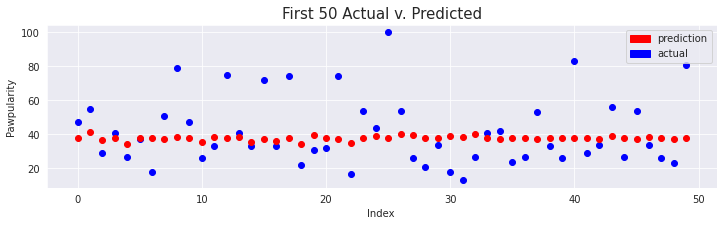

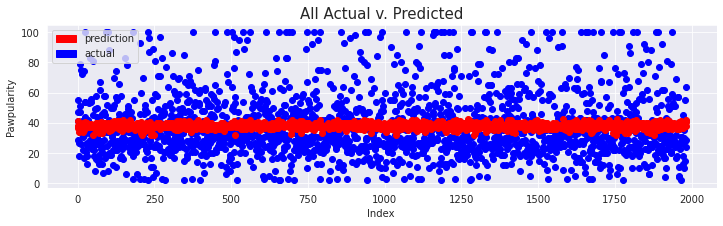

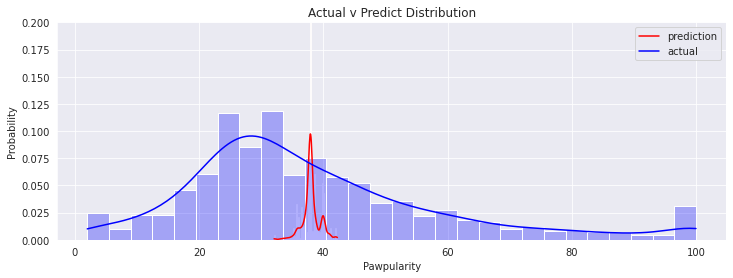

In [12]:
def ActualvPredictionsGraph(y_test,y_pred,title):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.figure(figsize=(12,3))
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.xlabel('Index ')
    plt.ylabel('Pawpularity ')
    plt.title(title,fontdict = {'fontsize' : 15})
    plt.legend(handles = [mpatches.Patch(color='red', label='prediction'),mpatches.Patch(color='blue', label='actual')])
    plt.show()
    return

# 绘图
ActualvPredictionsGraph(y_valid[0:50], RF_pred[0:50], "First 50 Actual v. Predicted")
ActualvPredictionsGraph(y_valid, RF_pred, "All Actual v. Predicted")

plt.figure(figsize=(12,4))
sns.histplot(RF_pred,color='r',alpha=0.3,stat='probability', kde=True)
sns.histplot(y_valid,color='b',alpha=0.3,stat='probability', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution')
plt.ylim([0.0, 0.2])
plt.show()


**Observations:**
* 无论元数据如何，所有 RF 预测都非常相似，它们接近训练集分布的均值
* 这和数据分析结果相一致：元数据不能很好地预测 Pawpularity。

In [13]:
X_test = test_df.drop(['Id'], axis=1)
test_df['Pawpularity'] = RF.predict(X_test) 

# 保存结果
submission_df = test_df[['Id','Pawpularity']]
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,37.921790
1,43a2262d7738e3d420d453815151079e,39.448850
2,4e429cead1848a298432a0acad014c9d,37.764037
3,80bc3ccafcc51b66303c2c263aa38486,35.565539
4,8f49844c382931444e68dffbe20228f4,34.770268
